### *Roadmap*

    1. Get watershed
    2. Define intersection
    3. Parse through data sources
    4.  Prepare .nc files


In [1]:
from pathlib import Path
import glob

import geopandas as gpd
import pandas as pd

from osgeo import gdalconst

import numpy as np
import xarray as xr

from custom_functions.geo_processing import (polygon_area, find_extent,
                                             create_AOI, create_mosaic,
                                             reproject_and_clip)

from custom_functions.nc_processing import (lisflood_initial_grid,
                                            lisflood_val_grid,
                                            select_NC_by_extent,
                                            interpolate_XR)

from custom_functions.data_plot import (plot_grids)

from custom_functions.topography_calculations import (
    ldd_calculation, slope_calculation, upstr_area_calculation
)

from custom_functions.land_cover_calculations import (
    weighted_lc_value, calc_spam_part, crop_sum, final_crop
)


# import ee

# ee.Authenticate()

# ee.Initialize()


### Define extent of desired watershed and create AOI

In [5]:
geom_p = Path('./data/geometry')
topo_p = Path('./data/topography')
lc_p = Path('./data/landscape/')

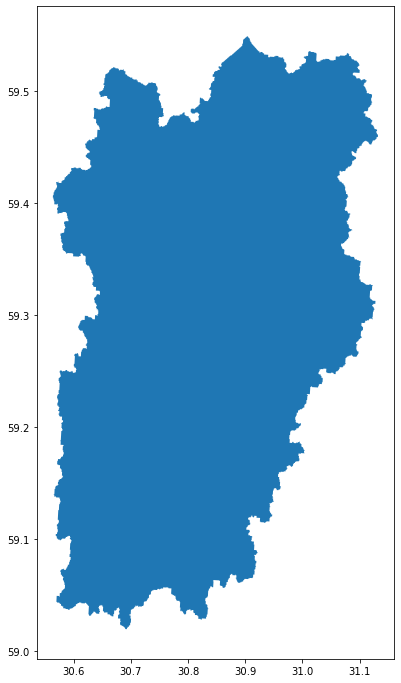

In [2]:
path_to_ws = Path(f'{geom_p}/TosnoTosno.shp')

tosno_ws = gpd.read_file(path_to_ws)
tosno_ws = tosno_ws.to_crs(epsg='4326')

tosno_ws.plot(figsize=(15, 12));

### Meteorological forcings

In [3]:
# create it from my script and ERA5 data

### Static maps

* Projection EPSG:4326 - WGS84: World Geodetic System 1984;

* Examples of horizontal resolution: 1’ (~1.86 km at the Equator) and 3’ (~5.57 km at the Equator);

* Examples of coverage and horizontal resolution: a) global domain: North = 90.00 N; South = 90.00 S; West = 180.00 W; East = 180.00 E; file size in grid-cells: 03’ = 7200x3600; b) European domain: North = 72.25 N; South = 22.75 N; West = 25.25 W; East = 50.25 E; file size in grid-cells: 01’ = 4530x2970;

* NoData value: 1) for Byte (Int8) files = 0; 2) for Real (Float32) files = -999999.0.

* Ocean masked with NoData (except, pixel length and pixel area maps).


### [General maps](https://ec-jrc.github.io/lisflood-code/4_Static-Maps_general-maps/)

#### Area mask map

To create a mask field (mask map or land use mask), source data (e.g. elevation or flow direction) values are changed to ‘1’ and the variable type is forced to be Byte for the mask map (area.nc), and Float32 for the land use mask (lusemask.nc).

If the source data is at a higher resolution and/or is larger than the required model domain, it needs to be re-scaled to the required grid-cell resolution and/or clipped to the required model domain.



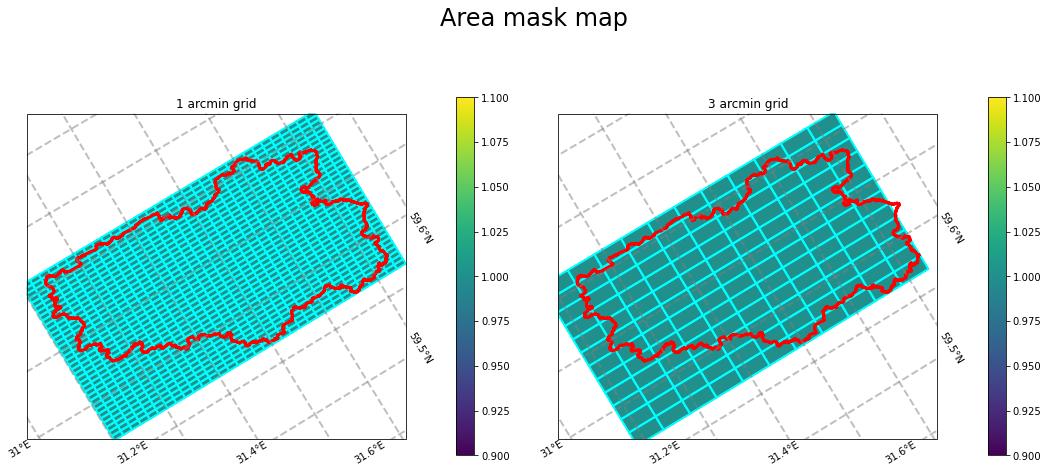

In [11]:
grid_3arcmin, polygons_3, lons_3, lats_3 = lisflood_initial_grid(resolution=3/60,
                                                       target_ws=tosno_ws)
grid_1arcmin, polygons_1, lons_1, lats_1 = lisflood_initial_grid(resolution=1/60,
                                                                 target_ws=tosno_ws)

plot_grids(target_ws=tosno_ws,
           grid_1=grid_1arcmin,
           poly_1=polygons_1,
           grid_3=grid_3arcmin,
           poly_3=polygons_3,
           grid_val_name='mask',
           map_name='Area mask map')


#### Land use mask

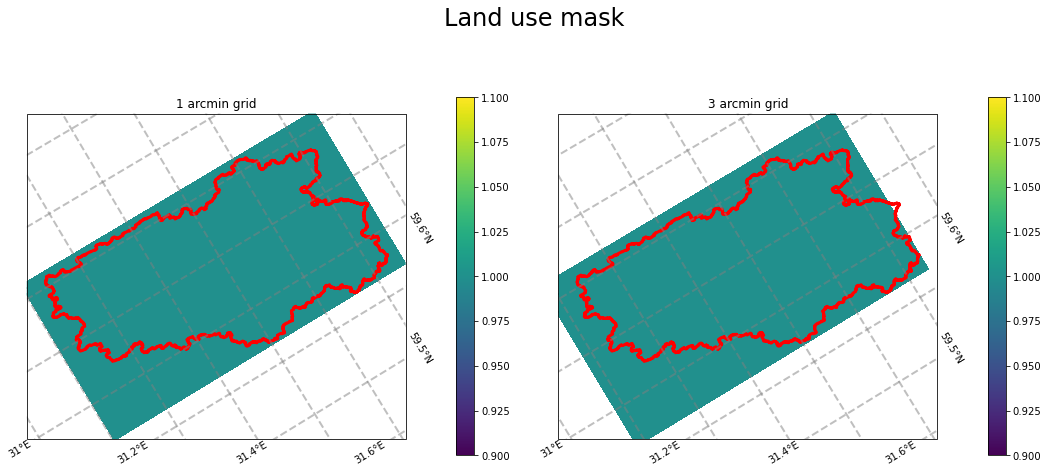

In [5]:
plot_grids(target_ws=tosno_ws,
           grid_1=grid_1arcmin,
           grid_3=grid_3arcmin,
           grid_val_name='mask',
           map_name='Land use mask')


#### Grid-cell length and grid-cell area maps

To create the grid-cell area, the ee.Image.pixelArea() function in Google Earth Engine can be used, that computes the value of each grid-cell in square meters considering all curves of the Globe, and specify the needed grids resolution (e.g. 1 and 3 arc min) along the longitude in meters.
Grid-cell length is computed dividing grid-cell area by its resolution along the longitude in meters.

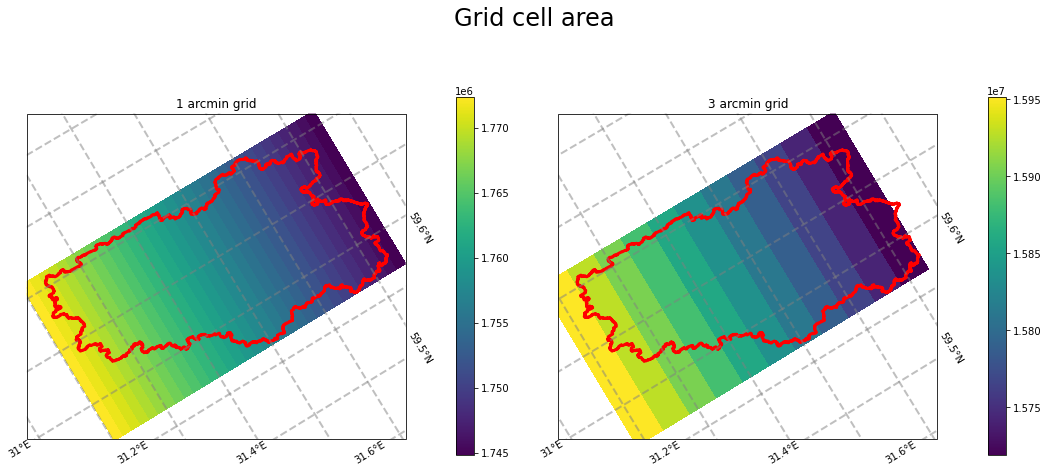

In [6]:
grid_cell_area_1 = lisflood_val_grid(grid_polygons=polygons_1,
                                     val_name='grid-cell area',
                                     vals=np.array([polygon_area(lats=poly.geometry.values[0].exterior.xy[1],
                                                                 lons=poly.geometry.values[0].exterior.xy[0])
                                                    for poly in polygons_1]).reshape(grid_1arcmin.mask.shape),
                                     desc='Grid cell area 1 arcmin')

grid_cell_area_3 = lisflood_val_grid(grid_polygons=polygons_3,
                                     val_name='grid-cell area',
                                     vals=np.array([polygon_area(lats=poly.geometry.values[0].exterior.xy[1],
                                                                 lons=poly.geometry.values[0].exterior.xy[0])
                                                    for poly in polygons_3]).reshape(grid_3arcmin.mask.shape),
                                     desc='Grid cell area 3 arcmin')

plot_grids(target_ws=tosno_ws,
           grid_1=grid_cell_area_1,
           grid_3=grid_cell_area_3,
           grid_val_name='grid-cell area',
           map_name='Grid cell area')


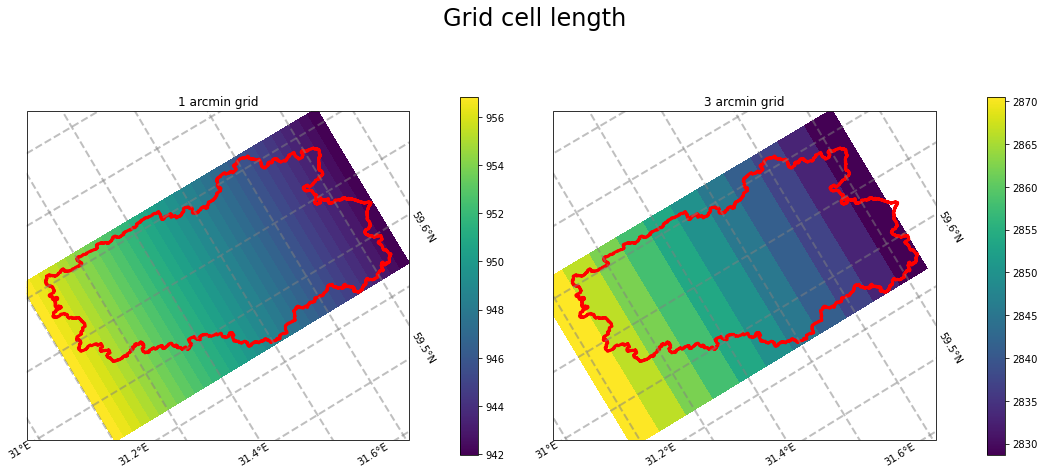

In [7]:
cell_length_1 = (grid_cell_area_1 / (1/60 * 111139))['grid-cell area'].data
cell_length_3 = (grid_cell_area_3 / (3/60 * 111139))['grid-cell area'].data

grid_cell_len_1 = lisflood_val_grid(grid_polygons=polygons_1,
                                    val_name='cell length',
                                    vals=cell_length_1,
                                    desc='Grid cell length 1 arcmin')

grid_cell_len_3 = lisflood_val_grid(grid_polygons=polygons_3,
                                    val_name='cell length',
                                    vals=cell_length_3,
                                    desc='Grid cell length 3 arcmin')

plot_grids(target_ws=tosno_ws,
           grid_1=grid_cell_len_1,
           grid_3=grid_cell_len_3,
           grid_val_name='cell length',
           map_name='Grid cell length')


### [Topography maps](https://ec-jrc.github.io/lisflood-code/4_Static-Maps_topography/)

#### Local drain direction map
The local drain direction (ldd) in a distributed hydrological model is the essential component to connect the grid cells to express the flow direction from one cell to another and forming a river network from springs to mouth. Currently LISFLOOD hydrological model needs ldd in PCRaster file format

In [7]:
tile_boundaries = ['n55e025', 'n55e030', 'n60e025', 'n60e030']
# f'n55_e030_{var}'
variables = ['dir', 'elv']

nw_tiles = {var: [item for sublist in 
                  [glob.glob(f'{topo_p}/**/{boundary}_{var}.tif',
                            recursive=True)
                  for boundary in tile_boundaries]
                  for item in sublist]
            for var in variables}


In [12]:
supplementary_files = Path('./supplementary_files')
supplementary_files.mkdir(exist_ok=True)

test_gdf_1, gdf_1_fpath = create_AOI(polygons=polygons_1,
                                     file_path=supplementary_files,
                                     file_name='AOI_1')

test_gdf_3, gdf_3_fpath = create_AOI(polygons=polygons_3,
                                     file_path=supplementary_files,
                                     file_name='AOI_3')

In [7]:
nw_dem = create_mosaic(file_path=supplementary_files,
                       file_name='nw_dem',
                       tiles=nw_tiles['elv'])

elv_1 = reproject_and_clip(input_raster=nw_dem,
                           output_raster=f'{supplementary_files}/AOI_1_elv.tif',
                           projection='EPSG:4326',
                           shapefile=gdf_1_fpath,
                           resolution=1/60)

elv_3 = reproject_and_clip(input_raster=nw_dem,
                           output_raster=f'{supplementary_files}/AOI_3_elv.tif',
                           projection='EPSG:4326',
                           shapefile=gdf_3_fpath,
                           resolution=3/60)


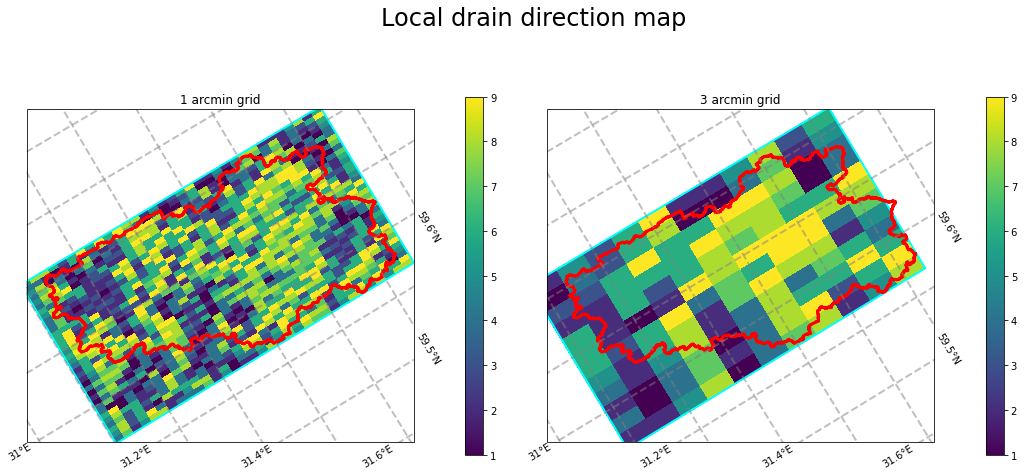

In [11]:
ldd_1 = ldd_calculation(src_filename=elv_1,
                        dst_fpath=topo_p,
                        dst_fname='ldd_1',
                        ot=gdalconst.GDT_Float32,
                        VS='VS_SCALAR',
                        polygons=polygons_1)
                        # resolution=1/60)


ldd_3 = ldd_calculation(src_filename=elv_3,
                        dst_fpath=topo_p,
                        dst_fname='elv_3',
                        ot=gdalconst.GDT_Float32,
                        VS='VS_SCALAR',
                        polygons=polygons_3)
                        # resolution=3/60)


plot_grids(target_ws=tosno_ws,
           grid_1=ldd_1,
           poly_1=[test_gdf_1],
           grid_3=ldd_3,
           poly_3=[test_gdf_3],
           grid_val_name='ldd',
           map_name='Local drain direction map')

#### Slope gradient map

Elevation data and its derivate (e.g. slope) are used in hydrological models for snow processes and for routing of surface runoff. In the LISFLOOD model the slope gradient map is used for surface routing.

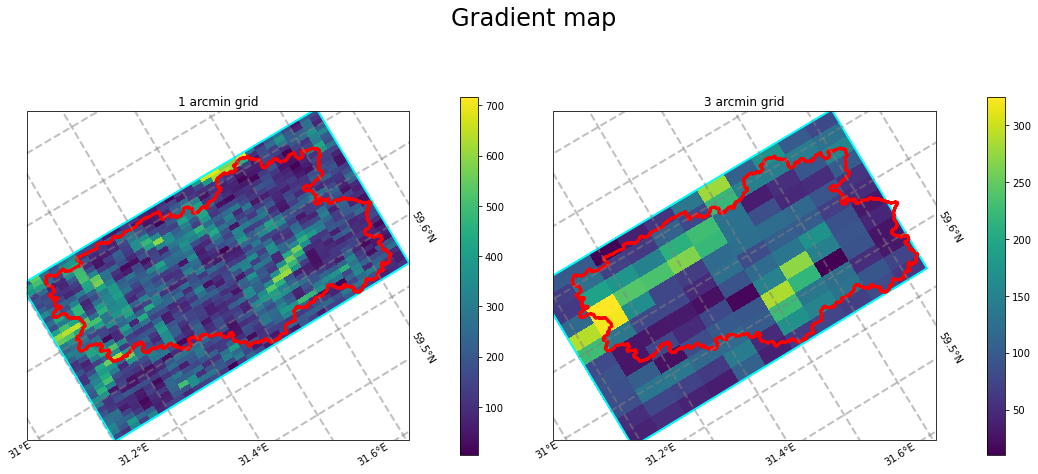

In [12]:
slope_1 = slope_calculation(src_filename=elv_1,
                            dst_fpath=topo_p,
                            dst_fname='slope_1',
                            ot=gdalconst.GDT_Float32,
                            VS='VS_SCALAR',
                            polygons=polygons_1)

slope_3 = slope_calculation(src_filename=elv_3,
                            dst_fpath=topo_p,
                            dst_fname='slope_3',
                            ot=gdalconst.GDT_Float32,
                            VS='VS_SCALAR',
                            polygons=polygons_3)

plot_grids(target_ws=tosno_ws,
           grid_1=slope_1,
           poly_1=[test_gdf_1],
           grid_3=slope_3,
           poly_3=[test_gdf_3],
           grid_val_name='slope',
           map_name='Gradient map')


#### Standard deviation of elevation map
Elevation data and its derivate (e.g. standard deviation of elevation) are used in hydrological models (e.g. the LISFLOOD model) for snow processes and for routing of surface runoff. In the LISFLOOD model the slope gradient map is used for surface routing.


In [13]:
std_elv_1 = reproject_and_clip(input_raster=nw_dem,
                               output_raster=f'{supplementary_files}/AOI_1_std_elv.tif',
                               projection='EPSG:4326',
                               shapefile=gdf_1_fpath)

std_elv_3 = reproject_and_clip(input_raster=nw_dem,
                               output_raster=f'{supplementary_files}/AOI_3_std_elv.tif',
                               projection='EPSG:4326',
                               shapefile=gdf_3_fpath)


initial_elevation = xr.open_dataset(std_elv_1, engine='rasterio')

std_grid_1 = np.array([select_NC_by_extent(initial_elevation,
                                         poly.geometry.values[0]).band_data.std().values
                     for poly in polygons_1]).reshape(grid_1arcmin.mask.shape)

std_1 = lisflood_val_grid(grid_polygons=polygons_1,
                          val_name='std',
                          vals=std_grid_1,
                          desc='Standard deviation of elevation map')

std_grid_3 = np.array([select_NC_by_extent(initial_elevation,
                                         poly.geometry.values[0]).band_data.std().values
                     for poly in polygons_3]).reshape(grid_3arcmin.mask.shape)

std_3 = lisflood_val_grid(grid_polygons=polygons_3,
                          val_name='std',
                          vals=std_grid_3,
                          desc='Standard deviation of elevation map')



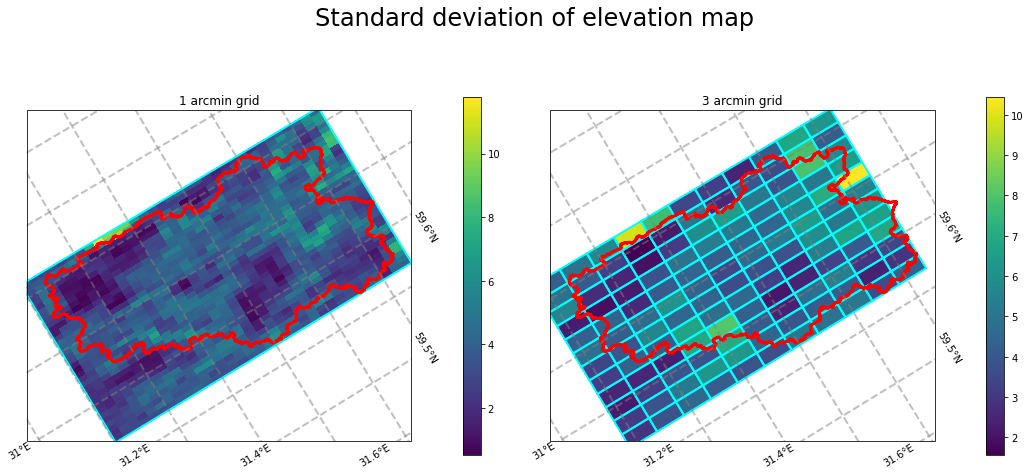

In [14]:
plot_grids(target_ws=tosno_ws,
           grid_1=std_1,
           poly_1=[test_gdf_1],
           grid_3=std_3,
           poly_3=polygons_3,
           grid_val_name='std',
           map_name='Standard deviation of elevation map')

#### Map with upstream area

The upstream area in a distributed hydrological model is the accumulated area of all connected water pixels that in a river network starts at the springs and goes to the river mouth. Springs grid-cells have lowest values, and river mouth grid-cells have the highest values on the map

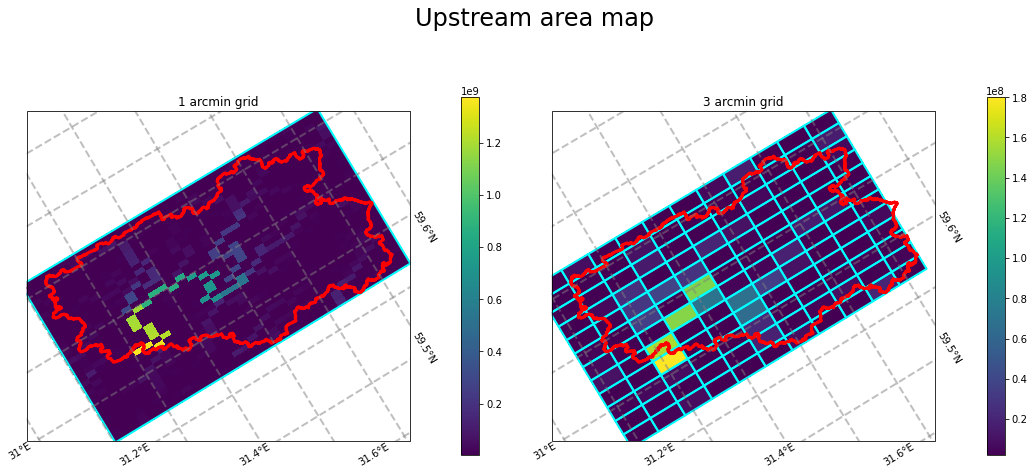

In [15]:
up_area_1 = upstr_area_calculation(src_filename=elv_1,
                                   dst_fpath=topo_p,
                                   dst_fname='up_area_1',
                                   ot=gdalconst.GDT_Float32,
                                   VS='VS_SCALAR') * 10**6
upstream_area_1 = lisflood_val_grid(grid_polygons=polygons_1,
                                    val_name='up_area',
                                    vals=up_area_1,
                                    desc='Upstream area')

up_area_3 = upstr_area_calculation(src_filename=elv_3,
                                   dst_fpath=topo_p,
                                   dst_fname='up_area_3',
                                   ot=gdalconst.GDT_Float32,
                                   VS='VS_SCALAR') * 10**6
upstream_area_3 = lisflood_val_grid(grid_polygons=polygons_3,
                                    val_name='up_area',
                                    vals=up_area_3,
                                    desc='Upstream area')

plot_grids(target_ws=tosno_ws,
           grid_1=upstream_area_1,
           poly_1=[test_gdf_1],
           grid_3=upstream_area_3,
           poly_3=polygons_3,
           grid_val_name='up_area',
           map_name='Upstream area map')

### [Land Use](https://ec-jrc.github.io/lisflood-code/4_Static-Maps_land-use/)

In [8]:
nw_tiles['forest'] = glob.glob(f'{lc_p}/**/*Tree-CoverFraction*.tif',
                               recursive=True)
nw_tiles['sealed'] = glob.glob(f'{lc_p}/**/*BuiltUp*.tif',
                               recursive=True)
nw_tiles['perma_water'] = glob.glob(f'{lc_p}/**/*PermanentWater*.tif',
                                    recursive=True)



#### Fraction of inland water map

Inland water map includes information on rivers, freshwater and saline lakes, ponds and other permanent water bodies over the continents. In the LISFLOOD model the inland water fraction map is used to identify the fraction of the pixel covered by open water bodies where the most prominent hydrological process is evaporation. Considering that LISFLOOD does not distinguish oceans from inland water it is recommended to verify consistency between water fractions and computational area mask, especially in the coastal areas. Pixels included in the computational area mask cannot be fully covered with ocean. If this happens in coastal areas, then the fraction of inland water must be set to 1 and the lake mask should be changed accordingly.

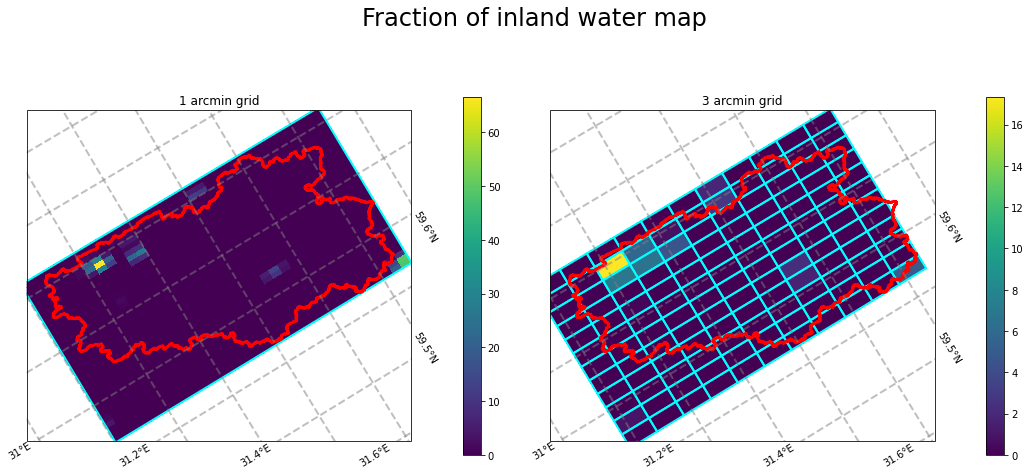

In [13]:
inland_water = create_mosaic(file_path=supplementary_files,
                             file_name='inland_water',
                             tiles=nw_tiles['perma_water'])

inland_water_AOI = reproject_and_clip(input_raster=inland_water,
                                      output_raster=f'{supplementary_files}/inland_water.tif',
                                      projection='EPSG:4326',
                                      shapefile=gdf_1_fpath)


inland_water_1arcmin = weighted_lc_value(nc_dataset=inland_water_AOI,
                                         polygons=polygons_1,
                                         shape=grid_1arcmin.mask.shape)
inland_water_nc_1 = lisflood_val_grid(grid_polygons=polygons_1,
                                      val_name='inland_water',
                                      vals=inland_water_1arcmin,
                                      desc='Fraction of inland water map')


inland_water_3arcmin = weighted_lc_value(nc_dataset=inland_water_AOI,
                                         polygons=polygons_3,
                                         shape=grid_3arcmin.mask.shape)
inland_water_nc_3 = lisflood_val_grid(grid_polygons=polygons_3,
                                      val_name='inland_water',
                                      vals=inland_water_3arcmin,
                                      desc='Fraction of inland water map')


plot_grids(target_ws=tosno_ws,
           grid_1=inland_water_nc_1,
           poly_1=[test_gdf_1],
           grid_3=inland_water_nc_3,
           poly_3=polygons_3,
           grid_val_name='inland_water',
           map_name='Fraction of inland water map')


#### Fraction of sealed surface map

Here, the sealed surface map describes urban areas, characterizing the human impact on the environment. In the LISFLOOD model the sealed surface fraction map is used to identify impervious areas where there is no water infiltration into the soil, meaning water is accumulated in the surface depression, yet evaporates, but once depression is full - water is transported by a surface runoff.

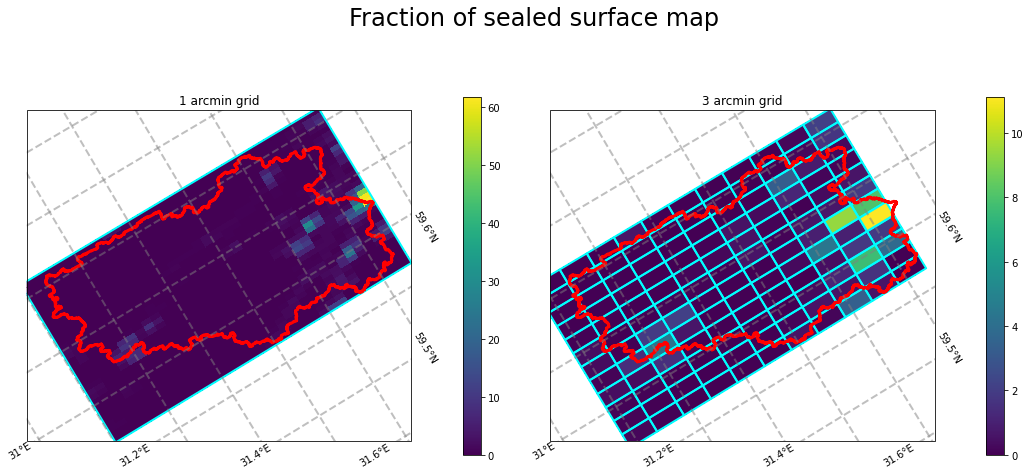

In [18]:
sealed = create_mosaic(file_path=supplementary_files,
                       file_name='sealed',
                       tiles=nw_tiles['sealed'])

sealed_AOI = reproject_and_clip(input_raster=sealed,
                                output_raster=f'{supplementary_files}/sealed.tif',
                                projection='EPSG:4326',
                                shapefile=gdf_1_fpath)


sealed_1arcmin = weighted_lc_value(nc_dataset=sealed_AOI,
                                   polygons=polygons_1,
                                   shape=grid_1arcmin.mask.shape)
sealed_nc_1 = lisflood_val_grid(grid_polygons=polygons_1,
                                val_name='sealed',
                                vals=sealed_1arcmin,
                                desc='Fraction of sealed surface map') * 0.75


sealed_3arcmin = weighted_lc_value(nc_dataset=sealed_AOI,
                                   polygons=polygons_3,
                                   shape=grid_3arcmin.mask.shape)
sealed_nc_3 = lisflood_val_grid(grid_polygons=polygons_3,
                                val_name='sealed',
                                vals=sealed_3arcmin,
                                desc='Fraction of sealed surface map') * 0.75


plot_grids(target_ws=tosno_ws,
           grid_1=sealed_nc_1,
           poly_1=[test_gdf_1],
           grid_3=sealed_nc_3,
           poly_3=polygons_3,
           grid_val_name='sealed',
           map_name='Fraction of sealed surface map')


#### Fraction of forest map

Forest map describes land use composed of evergreen and deciduous needle leaf and broad leaf trees. In the LISFLOOD model the forest fraction is used to identify forested areas where main hydrological processes are canopy interception, evapotranspiration from canopies, canopies drainage and evapotranspiration.

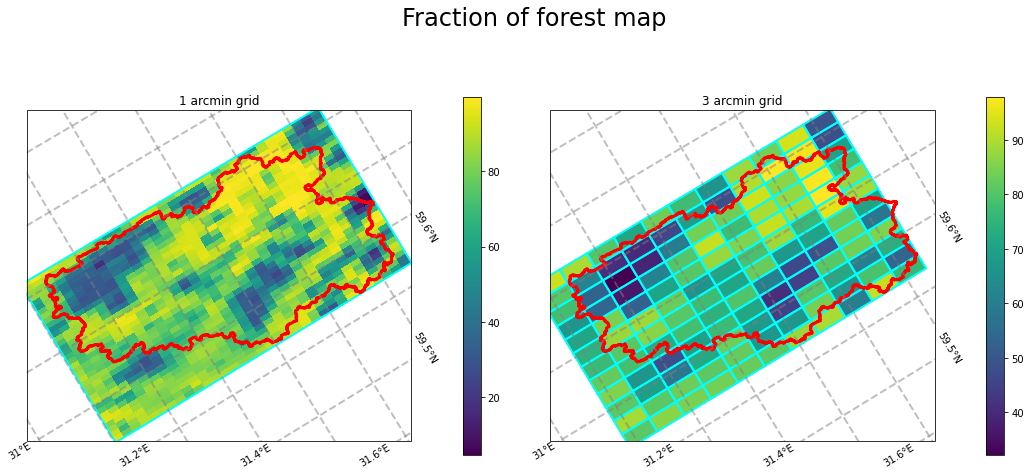

In [19]:
forest = create_mosaic(file_path=supplementary_files,
                       file_name='forest',
                       tiles=nw_tiles['forest'])

forest_AOI = reproject_and_clip(input_raster=forest,
                                output_raster=f'{supplementary_files}/forest.tif',
                                projection='EPSG:4326',
                                shapefile=gdf_1_fpath)


forest_1arcmin = weighted_lc_value(nc_dataset=forest_AOI,
                                   polygons=polygons_1,
                                   shape=grid_1arcmin.mask.shape)
forest_nc_1 = lisflood_val_grid(grid_polygons=polygons_1,
                                val_name='forest',
                                vals=forest_1arcmin,
                                desc='Fraction of forest map')


forest_3arcmin = weighted_lc_value(nc_dataset=forest_AOI,
                                   polygons=polygons_3,
                                   shape=grid_3arcmin.mask.shape)
forest_nc_3 = lisflood_val_grid(grid_polygons=polygons_3,
                                val_name='forest',
                                vals=forest_3arcmin,
                                desc='Fraction of forest map')


plot_grids(target_ws=tosno_ws,
           grid_1=forest_nc_1,
           poly_1=[test_gdf_1],
           grid_3=forest_nc_3,
           poly_3=polygons_3,
           grid_val_name='forest',
           map_name='Fraction of forest map')


#### Fraction of irrigated crops map

Irrigated crops map includes all possible crops excluding rice (is modelled separately). In the LISFLOOD model the irrigated crops fraction map is used to identify part of the pixel which is used by agriculture - water is abstracted from ground water and surface water bodies to irrigate the fields; main hydrological process connected with the irrigated crops are canopy interception, evapotranspiration from canopies, canopies drainage and evapotranspiration.

In [28]:
irrigation_info = glob.glob(f'{lc_p}/*.csv/*.csv')

spam_dataset=pd.read_csv(irrigation_info[0], encoding='cp1252')
min_lon, max_lon, min_lat, max_lat = find_extent(tosno_ws.geometry.values[0])

# define crops except rice
crop_vals = [spam_dataset.columns[9]]+ list(spam_dataset.columns[11:51])
rice_vals = spam_dataset.columns[10]

res_list_1 = list()
res_list_3 = list()
from tqdm.notebook import tqdm

for crop in tqdm(crop_vals):
    res_list_1.append(calc_spam_part(spam_ds=spam_dataset,
                          target_ws=tosno_ws.geometry.values[0],
                          crop_variable=str(crop),
                          polygons=polygons_1,
                          nc_file_to_save=f'{supplementary_files}/{crop}',
                          tif_file_to_save=f'{supplementary_files}/{crop}',
                          grid=grid_1arcmin,
                          grid_res='1',
                          lats_grid=lats_1,
                          lons_grid=lons_1))
    
    res_list_3.append(calc_spam_part(spam_ds=spam_dataset,
                        target_ws=tosno_ws.geometry.values[0],
                        crop_variable=str(crop),
                        polygons=polygons_3,
                        nc_file_to_save=f'{supplementary_files}/{crop}',
                        tif_file_to_save=f'{supplementary_files}/{crop}',
                        grid=grid_3arcmin,
                        grid_res='3',
                        lats_grid=lats_3,
                        lons_grid=lons_3))
    

from functools import reduce


def crop_sum(a, b):
    return np.where(np.isnan(a+b), np.where(np.isnan(a),
                                            b, a),
                    a+b)


def final_crop(crop_grids: list,
               grid_shape: tuple):
    
    fin_arr = np.empty(shape=grid_shape)
    fin_arr[:] = np.NaN

    for crop_arr in crop_grids:
        fin_arr = crop_sum(crop_arr, fin_arr)
    
    return np.nan_to_num(fin_arr)

crop_1 = final_crop(res_list_1,
                    grid_1arcmin.mask.shape)
crop_3 = final_crop(res_list_3,
                    grid_3arcmin.mask.shape)

crop_nc_1 = lisflood_val_grid(grid_polygons=polygons_1,
                                val_name='crop',
                                vals=crop_1,
                                desc='Fraction of irrigated crops')


crop_nc_3 = lisflood_val_grid(grid_polygons=polygons_3,
                                val_name='crop',
                                vals=crop_3,
                                desc='Fraction of irrigated crops')

plot_grids(target_ws=tosno_ws,
           grid_1=crop_nc_1,
           poly_1=[test_gdf_1],
           grid_3=crop_nc_3,
           poly_3=[test_gdf_3],
           grid_val_name='crop',
           map_name='Fraction of irrigated crops')


  0%|          | 0/41 [00:00<?, ?it/s]

/tmp/ipykernel_13914/208344610.py:141: RuntimeWarning: Mean of empty slice
  res_ds = np.array([np.nanmean(res_interim)
/tmp/ipykernel_13914/208344610.py:141: RuntimeWarning: Mean of empty slice
  res_ds = np.array([np.nanmean(res_interim)
/tmp/ipykernel_13914/208344610.py:141: RuntimeWarning: Mean of empty slice
  res_ds = np.array([np.nanmean(res_interim)
/tmp/ipykernel_13914/208344610.py:141: RuntimeWarning: Mean of empty slice
  res_ds = np.array([np.nanmean(res_interim)
/tmp/ipykernel_13914/208344610.py:141: RuntimeWarning: Mean of empty slice
  res_ds = np.array([np.nanmean(res_interim)
/tmp/ipykernel_13914/208344610.py:141: RuntimeWarning: Mean of empty slice
  res_ds = np.array([np.nanmean(res_interim)
/tmp/ipykernel_13914/208344610.py:141: RuntimeWarning: Mean of empty slice
  res_ds = np.array([np.nanmean(res_interim)
/tmp/ipykernel_13914/208344610.py:141: RuntimeWarning: Mean of empty slice
  res_ds = np.array([np.nanmean(res_interim)
/tmp/ipykernel_13914/208344610.py:141: R

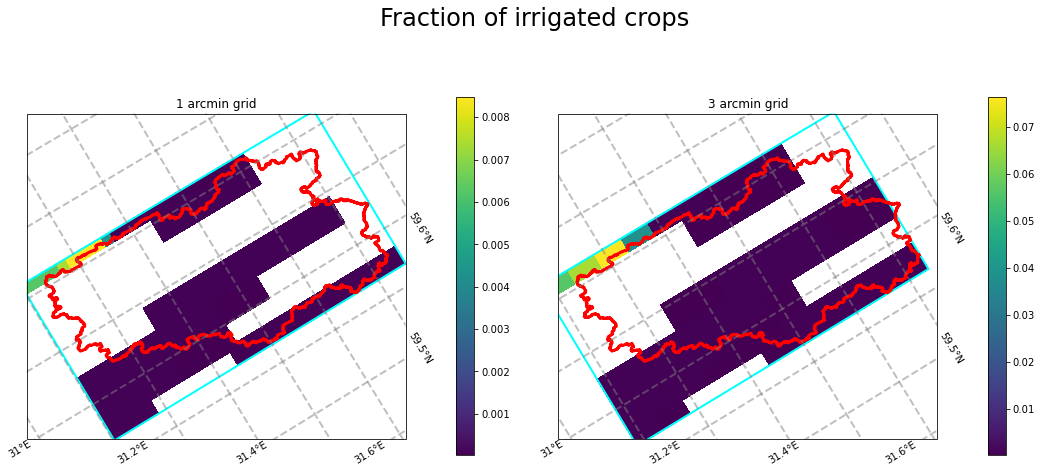

In [37]:
crop_nc_3.to_netcdf('crop_nc_3.nc')
crop_nc_1.to_netcdf('crop_nc_1.nc')

#### Fraction of other land cover type map

Other land cover type map includes agricultural areas, non-forested natural area, pervious surface of urban areas. In the LISFLOOD model the other land cover type fraction map is used in the following hydrological processes: canopy interception, evaporation from the canopies, canopy drainage, plant evapotranspiration, evaporation from the soil. The relative importance of these processes depends on the Leaf Area Index.



### [Land use depending](https://ec-jrc.github.io/lisflood-code/4_Static-Maps_land-use-depending/)

#### Crop coefficient

 for forest, irrigated crops and other land use type maps Crop coefficient is a simple ratio between the potential (reference) evapotranspiration rate, in mm/day, and the potential evaporation rate of a specific crop. In the LISFLOOD model the crop coefficient for forest, irrigated crops and other land cover type maps are used in the computation of the transpiration rate for the forest, irrigated agriculture and other land cover type fractions respectively, e.g. in the computation of the roots water uptake to support plant transpiration.)

#### Crop group number

for forest, irrigated crops and other land use type maps The crop group number represents a vegetation type and is an indicator of its adaptation to dry climate. In the LISFLOOD model the crop group number for forest, irrigated crops and other land cover type maps are used in the computation of the critical amount of soil moisture wcrit below which water uptake from plants is reduced as they start closing their stomata. The crop group number for forest, irrigated crops and other land cover type are applied to the forest, irrigated agriculture and other land cover type fractions respectively.


#### Manning’s surface roughness coefficient

for forest, irrigated crops and other land cover type maps Manning’s surface roughness coefficient represents the roughness or friction applied to the flow by the surface on which water is flowing. In the LISFLOOD model the Manning’s surface roughness coefficients for forest, irrigated crops and other land cover type maps are used to compute surface runoff routing for the forest, irrigated agriculture and other land cover type fractions respectively.

#### Soil depth layers 1, 2 and 3

for forested and non-forested areas maps Soil depth is used to compute the available water storage volume in the soil. In the LISFLOOD model, three soil layers are used to model the hydrological processes in the soil. The layers take into account forest and non-forest root depths to divide the total soil depth between topsoil (surface layer or layer 1, and middle layer or layer 2) and subsoil (bottom layer or layer 3) hydrological processes.


### [Soil hydraulic properties](https://ec-jrc.github.io/lisflood-code/4_Static-Maps_soil-hydraulic-properties/)

#### Theta saturated (thetas)

 is the saturated water content soil hydraulic property representing the maximum water content in the soil.

#### Theta residual (thetar)
is the residual water content soil hydraulic property representing the minimum water content in the soil.

#### Lambda is the Van Genuchten parameter λ (also referred as ‘n-1’ in literature)

soil hydraulic property representing the pore size index of the soil.

#### Genu alpha (genua)

is the Van Genuchten parameter α soil hydraulic property.

#### K saturated (Ksat)

is the saturated hydraulic conductivity soil hydraulic property describing the ease with which water moves through pore spaces of the soil.

### [Channel geometry](https://ec-jrc.github.io/lisflood-code/4_Static-Maps_channel-geometry/)

#### The channel mask map

is the Boolean field with ‘1’ for all grid-cells with channels and NoData for all grid-cells with no channels.


#### The channel side slope map

(referred as ‘s’ in Figure 41) defines the slope of the channel banks.

#### The channel length map

is the length of the river in each grid-cell, and the value can exceed grid-size to account for meandering rivers


#### The channel gradient (or channel slope) map

is the average gradient of the main river inside a cell.

#### The Manning’s roughness coefficient map

can be derived by an empirical relationship of the DEM and the upstream area according to Burek et al. (2014). The kinematic wave approach uses the Manning’s formula, an empirical formula for open channel flow or free-surface flow driven by gravity. The Manning’s roughness coefficient is reciprocal proportional to the cross-sectional average velocity (in m/s). A lower Manning’s coefficient results in a faster responding time at the outlet.

#### The bottom width map

(referred as Wb in Figure 41) is the width of the bottom of the channel.

#### The floodplain map

(referred as Wfp in Figure 41) is used to calculate water levels in the LISFLOOD model.

#### The bankfull channel depth map

(referred as Dbf in Figure 41) is the difference between floodplain bottom level (referred as zfp in Figure 41) and the channel bottom level (referred as zbot in Figure 41.

### [Leaf Area Index](https://ec-jrc.github.io/lisflood-code/4_Static-Maps_leaf-area-index/)

### [Reservoirs and lakes](https://ec-jrc.github.io/lisflood-code/4_Static-Maps_reservoirs-lakes/)

#### Lake mask map

In the LISFLOOD model lake mask map represents the area covered by lakes and is used for computing evaporation from open water surfaces

#### Lakes and reservoirs maps

### [Rice calendar](https://ec-jrc.github.io/lisflood-code/4_Static-Maps_rice-calendar/)